In [1]:
'''
Segment the OASIS brain data set with an Improved UNet.

@author Aghnia Prawira (45610240)
'''

import data_processing as dp
import improved_unet as iu
from importlib import reload
reload(dp)
reload(iu)

import os
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


Tensorflow version: 2.1.0
Tensorflow version: 2.1.0


In [2]:
dp.test()
iu.test()

Testing data processing.
Testing improved unet.


In [3]:
# Set path to dataset
dataset_path = "keras_png_slices_data/"

seg_test_path = dataset_path + "keras_png_slices_seg_test/"
seg_train_path = dataset_path + "keras_png_slices_seg_train/"
seg_val_path = dataset_path + "keras_png_slices_seg_validate/"
test_path = dataset_path + "keras_png_slices_test/"
train_path = dataset_path + "keras_png_slices_train/"
val_path = dataset_path + "keras_png_slices_validate/"

In [4]:
# Load images
reload(dp)
seg_test = dp.load_seg(seg_test_path)
seg_train = dp.load_seg(seg_train_path)
seg_val = dp.load_seg(seg_val_path)
test = dp.load_image(test_path)
train = dp.load_image(train_path)
val = dp.load_image(val_path)

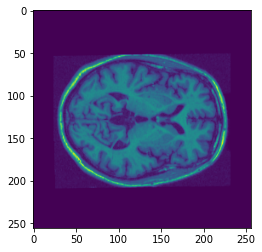

In [8]:
plt.imshow(test[0])

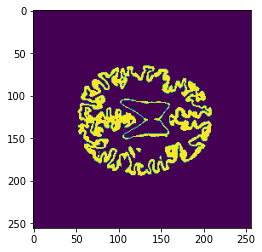

In [9]:
plt.imshow(seg_test[0][:,:,2])

In [ ]:
# One hot encode labels
# seg_test = dp.one_hot_encode(seg_test)

In [ ]:
# seg_train = dp.one_hot_encode(seg_train)

In [ ]:
# seg_val = dp.one_hot_encode(seg_val)

In [ ]:
# plt.imshow(seg_train[0][:,:,2])

In [10]:
print(np.array(train).shape)
print(np.array(seg_train).shape)

(200, 256, 256, 1)
(200, 256, 256, 4)


In [20]:
reload(iu)
# Generate improved unet model
model = iu.unet()

Tensorflow version: 2.1.0
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 256, 256, 16) 160         input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_51 (LeakyReLU)      (None, 256, 256, 16) 0           conv2d_53[0][0]                  
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 256, 256, 16) 2320        leaky_re_lu_51[0][0]             
__________________________________________________________________

In [21]:
# Compile the model
reload(iu)
model.compile(optimizer='adam', 
              loss='binary_crossentropy', metrics=[iu.dice_coefficient_avg])

# model.compile(optimizer='adam', 
#               loss=iu.dice_loss, metrics=[iu.dice_coefficient_avg])

Tensorflow version: 2.1.0


In [45]:
# Train the model
history = model.fit(np.array(train), np.array(seg_train), 
                    batch_size=32, epochs=200, 
                    validation_data=(np.array(val), np.array(seg_val)))

Train on 200 samples, validate on 200 samples
Epoch 1/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0768 - dice_coefficient_avg: 0.9474 - val_loss: 0.1561 - val_dice_coefficient_avg: 0.9040
Epoch 2/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0762 - dice_coefficient_avg: 0.9479 - val_loss: 0.1593 - val_dice_coefficient_avg: 0.9032
Epoch 3/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0767 - dice_coefficient_avg: 0.9480 - val_loss: 0.1538 - val_dice_coefficient_avg: 0.9042
Epoch 4/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0762 - dice_coefficient_avg: 0.9484 - val_loss: 0.1587 - val_dice_coefficient_avg: 0.9041
Epoch 5/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0758 - dice_coefficient_avg: 0.9482 - val_loss: 0.1576 - val_dice_coefficient_avg: 0.9044
Epoch 6/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0756 - dice_coefficient_avg: 0.9484 

200/200 [==============================] - 2s 12ms/step - loss: 0.0602 - dice_coefficient_avg: 0.9602 - val_loss: 0.1888 - val_dice_coefficient_avg: 0.8974
Epoch 50/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0602 - dice_coefficient_avg: 0.9604 - val_loss: 0.1887 - val_dice_coefficient_avg: 0.8980
Epoch 51/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0598 - dice_coefficient_avg: 0.9606 - val_loss: 0.1885 - val_dice_coefficient_avg: 0.8970
Epoch 52/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0595 - dice_coefficient_avg: 0.9608 - val_loss: 0.1878 - val_dice_coefficient_avg: 0.8984
Epoch 53/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0592 - dice_coefficient_avg: 0.9611 - val_loss: 0.1900 - val_dice_coefficient_avg: 0.8973
Epoch 54/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0587 - dice_coefficient_avg: 0.9615 - val_loss: 0.1916 - val_dice_coefficient_avg: 0.8976

200/200 [==============================] - 3s 13ms/step - loss: 0.0505 - dice_coefficient_avg: 0.9671 - val_loss: 0.2130 - val_dice_coefficient_avg: 0.8933
Epoch 98/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0503 - dice_coefficient_avg: 0.9672 - val_loss: 0.2033 - val_dice_coefficient_avg: 0.8953
Epoch 99/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0503 - dice_coefficient_avg: 0.9674 - val_loss: 0.2138 - val_dice_coefficient_avg: 0.8931
Epoch 100/200
200/200 [==============================] - 3s 13ms/step - loss: 0.0493 - dice_coefficient_avg: 0.9683 - val_loss: 0.2121 - val_dice_coefficient_avg: 0.8938
Epoch 101/200
200/200 [==============================] - 3s 13ms/step - loss: 0.0490 - dice_coefficient_avg: 0.9684 - val_loss: 0.2135 - val_dice_coefficient_avg: 0.8936
Epoch 102/200
200/200 [==============================] - 3s 13ms/step - loss: 0.0489 - dice_coefficient_avg: 0.9683 - val_loss: 0.2184 - val_dice_coefficient_avg: 0.8

200/200 [==============================] - 2s 12ms/step - loss: 0.0428 - dice_coefficient_avg: 0.9727 - val_loss: 0.2317 - val_dice_coefficient_avg: 0.8914
Epoch 146/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0428 - dice_coefficient_avg: 0.9726 - val_loss: 0.2311 - val_dice_coefficient_avg: 0.8909
Epoch 147/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0424 - dice_coefficient_avg: 0.9729 - val_loss: 0.2361 - val_dice_coefficient_avg: 0.8904
Epoch 148/200
200/200 [==============================] - 3s 13ms/step - loss: 0.0428 - dice_coefficient_avg: 0.9728 - val_loss: 0.2300 - val_dice_coefficient_avg: 0.8917
Epoch 149/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0429 - dice_coefficient_avg: 0.9725 - val_loss: 0.2358 - val_dice_coefficient_avg: 0.8913
Epoch 150/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0427 - dice_coefficient_avg: 0.9727 - val_loss: 0.2314 - val_dice_coefficient_avg: 0

200/200 [==============================] - 2s 12ms/step - loss: 0.0390 - dice_coefficient_avg: 0.9754 - val_loss: 0.2436 - val_dice_coefficient_avg: 0.8899
Epoch 194/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0383 - dice_coefficient_avg: 0.9757 - val_loss: 0.2494 - val_dice_coefficient_avg: 0.8886
Epoch 195/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0383 - dice_coefficient_avg: 0.9758 - val_loss: 0.2451 - val_dice_coefficient_avg: 0.8895
Epoch 196/200
200/200 [==============================] - 3s 13ms/step - loss: 0.0383 - dice_coefficient_avg: 0.9757 - val_loss: 0.2494 - val_dice_coefficient_avg: 0.8889
Epoch 197/200
200/200 [==============================] - 3s 13ms/step - loss: 0.0379 - dice_coefficient_avg: 0.9759 - val_loss: 0.2468 - val_dice_coefficient_avg: 0.8893
Epoch 198/200
200/200 [==============================] - 2s 12ms/step - loss: 0.0378 - dice_coefficient_avg: 0.9762 - val_loss: 0.2502 - val_dice_coefficient_avg: 0

In [57]:
test_loss, test_acc = model.evaluate(np.array(test), np.array(seg_test), verbose=2)
print(test_acc)

0.8879291415214539


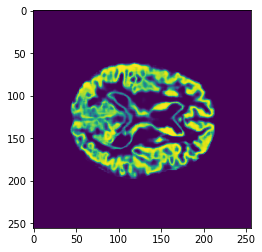

In [49]:
prediction = model.predict(np.array(test))
plt.imshow(prediction[4][:,:,2])

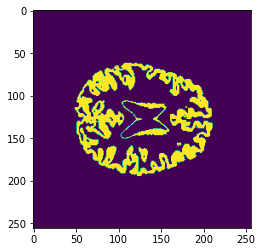

In [55]:
plt.imshow(seg_test[5][:,:,2])

In [37]:
reload(iu)
print(iu.dice_loss(np.array(seg_test), np.array(prediction)))
print(iu.dice_coefficient(np.array(seg_test), np.array(prediction)))

Tensorflow version: 2.1.0
tf.Tensor(0.085944295, shape=(), dtype=float32)
tf.Tensor(
[0.9055444  0.9082235  0.92146957 0.9235539  0.90740746 0.9205385
 0.92389446 0.9095008  0.9142234  0.9135255  0.9133284  0.914593
 0.91401213 0.90941334 0.9269339  0.9174607  0.9205174  0.90931576
 0.913706   0.9262937  0.9061687  0.9213442  0.9171655  0.9058203
 0.9274124  0.91228825 0.9116051  0.91818494 0.919591   0.90958303
 0.90657336 0.9171185  0.9138753  0.91774625 0.914091   0.915082
 0.90666586 0.91222715 0.9143638  0.91106665 0.91752064 0.9170817
 0.9026322  0.91527385 0.91710234 0.91940606 0.91839963 0.9185321
 0.91370827 0.9166875  0.9129958  0.919829   0.9109529  0.91880155
 0.919292   0.9123148  0.9190156  0.9193244  0.9126386  0.91543514
 0.9044947  0.9177161  0.91169196 0.92360497 0.90989786 0.9116853
 0.92633486 0.89155084 0.92463857 0.9162146  0.9146422  0.9180734
 0.90764064 0.9052748  0.92329454 0.92164207 0.8859188  0.9184647
 0.9095046  0.9104531  0.9239432  0.9039044  0.9142603 